# Predicting Subscription Status Based on Experience Level, Age, and Hours Played 

#### Anthony Lu, Ashley Lee, and Guneet Kaur

In [36]:
library(tidyverse)
library(janitor)
library(tidymodels)

### Introduction

#### Broad Question
* What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

#### Specific Question
* Can experience level, hours played, and age predict whether or not a player is subscribed to a game-related newsletter?

#### Relevant Dataset
* players.csv. Let's read it in!

In [37]:
players_url <- "https://raw.githubusercontent.com/anthonyl8/video_game_server_usage/refs/heads/main/players.csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Tidying the Data

Below, I've tidied the data by cleaning the column names and removing the two players with ages recorded as N/A. I've also mutated the experience column as described above.

In [38]:
players <- players |>
    clean_names() |>
    drop_na() |>
    mutate(experience = as_factor(experience), gender = as_factor(gender)) |>
    mutate(experience = as.integer(fct_recode(experience, "1" = "Beginner", "2" = "Amateur", "3" = "Regular", "4" = "Pro", "5" = "Veteran")))


### Addressing the Question

I'll be using k nearest neighbours classification, which is appropriate because I'm predicting a categorical variable using 3 quantitative predictor variables. This method requires few assumptions, which is good, but it may be sensitive to outliers. I will split my data into training and testing sets (at a 75/25 ratio), and I'll perform a 5-fold cross validation to determine the optimal k. Then, I'll use this k to create the final model and evaluate the model's performance to see if the 3 variables are good predictors for subscription status.

experience,subscribe,hashed_email,played_hours,name,gender,age
<int>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
2,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
3,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
3,FALSE,2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53,0.0,Quinlan,Male,22
2,FALSE,f8acd26a5e452b682b9f8b20108caef1ee2e745efe08e95806980bd2388a3fea,0.0,Finn,Male,23
2,FALSE,951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd,0.1,Vivienne,Male,18
3,FALSE,df6a1201c9c638aff1df8aeaf459a5b0a00aa04824936ee0305f5c275352c647,0.0,Vasco,Prefer not to say,33
5,FALSE,fa7d496b2f74c51ec70395bd8397b49f97a3ce8d7ba7e08887d82ec0008137a7,0.0,Umar,Male,24
4,FALSE,453774822d52d6891593948224570a750c4334616ff8aa74cd61fad9d4855752,0.0,Edmund,Prefer not to say,23
3,FALSE,5c27e8b9fed2816b006dc8397ec04470b59339fd591a46a3eb7951b939b72984,0.9,Pablo,Male,18


experience,subscribe,hashed_email,played_hours,name,gender,age
<int>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
3,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
4,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
3,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
3,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17
1,TRUE,4caa42e1b20511552434978171dcf7283fb6eb857eb871327e39bfc328002309,0.0,Daniela,Male,17
3,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,Female,17
4,TRUE,5baba1651a0b92788bc0d6dcdf00be64af1cf9f0015bbeed204ddabd1d872e83,0.6,Kendall,Female,28
3,TRUE,4b01bce3f141289709e8278b02ba5d2aaa7105d7ccb9c7deb37670a80e332774,1.8,Luca,Male,23
5,TRUE,f459ce1862ec9a43b6c714810390dfd632ed104eb11378b3a2a134b1b107bc75,0.6,Jabari,Male,26


K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5510345,5,0.02694072,Preprocessor1_Model001
1,roc_auc,binary,0.4657468,5,0.02384418,Preprocessor1_Model001
2,accuracy,binary,0.5310345,5,0.02522196,Preprocessor1_Model002
2,roc_auc,binary,0.4980674,5,0.04439320,Preprocessor1_Model002
3,accuracy,binary,0.6490312,5,0.03734135,Preprocessor1_Model003
3,roc_auc,binary,0.5478587,5,0.06526106,Preprocessor1_Model003
4,accuracy,binary,0.6490312,5,0.03734135,Preprocessor1_Model004
4,roc_auc,binary,0.6061031,5,0.07206745,Preprocessor1_Model004
5,accuracy,binary,0.6775862,5,0.05038496,Preprocessor1_Model005


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,accuracy,binary,0.7518391,5,0.01196231,Preprocessor1_Model025
26,accuracy,binary,0.7518391,5,0.01196231,Preprocessor1_Model026
27,accuracy,binary,0.7518391,5,0.01196231,Preprocessor1_Model027
28,accuracy,binary,0.7518391,5,0.01196231,Preprocessor1_Model028


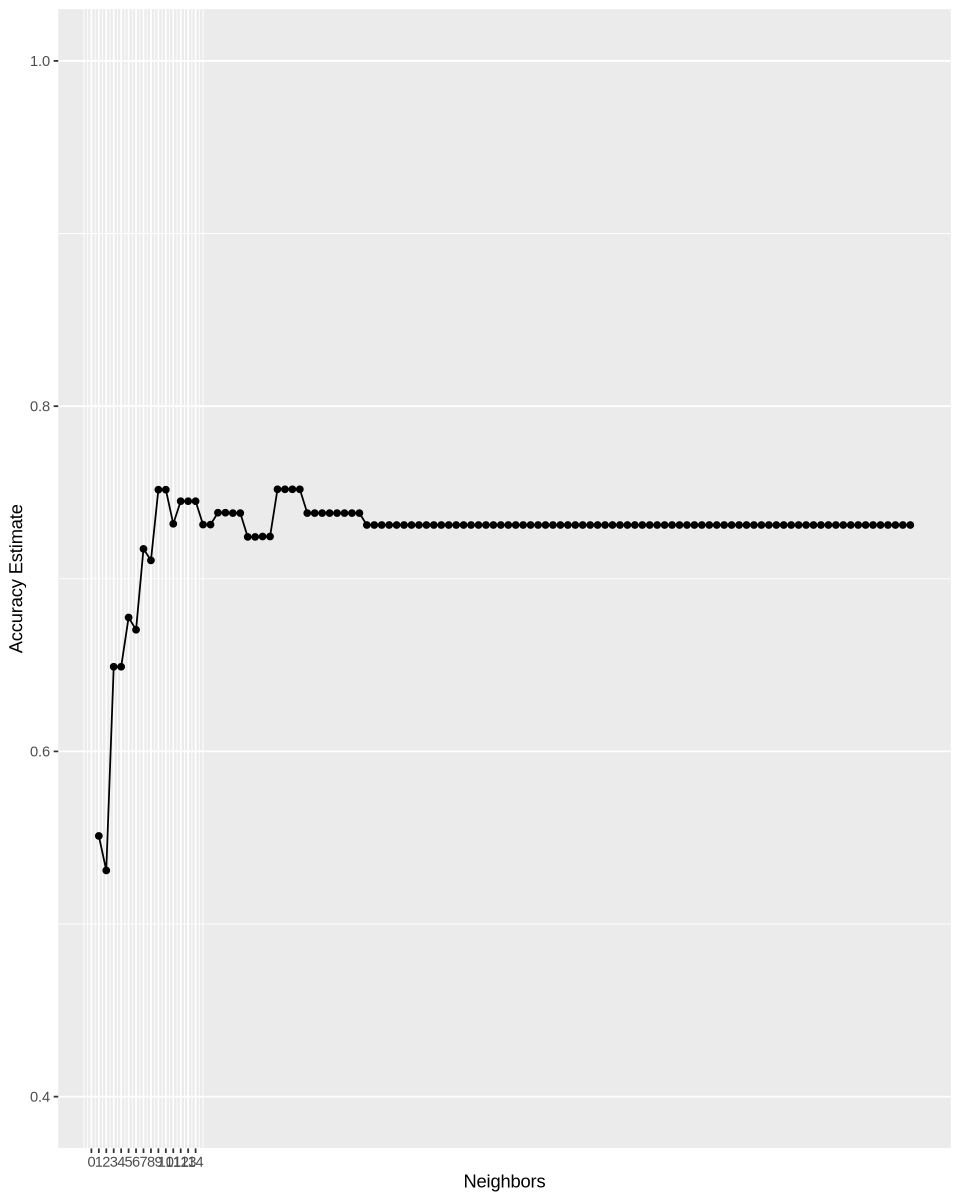

In [39]:
set.seed(3456) 

players <- players |> mutate(subscribe = as_factor(subscribe))

players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)
players_train
players_test

knn_tune <- nearest_neighbor(weight = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_tune

players_recipe <- recipe(subscribe ~ experience + played_hours + age, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())
players_recipe

k_vals <- tibble(neighbors = seq(from = 1, to = 110, by = 1))

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()

knn_results

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

max_accuracy <- accuracies |>
    filter(mean == max(accuracies$mean))
max_accuracy

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

In [45]:
mnist_spec <- nearest_neighbor(weight = "rectangular", neighbors = 25) |>
    set_engine("kknn") |>
    set_mode("classification")
mnist_spec

mnist_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(mnist_spec) |>
    fit(data = players_train)
mnist_fit

mnist_predictions <- predict(mnist_fit, players_test) |>
    bind_cols(players_test)

mnist_metrics <- mnist_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

mnist_conf_mat <- mnist_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

mnist_metrics
mnist_conf_mat

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 25
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(25,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2482759
Best kernel: rectangular
Best k: 25

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


          Truth
Prediction FALSE TRUE
     FALSE     1    2
     TRUE     12   34